# Using a neural network to emulate the atmospheric convection scheme in a global climate model 
### (John Dwyer & Paul O'Gorman)
## Overview: 
Global climate models (GCMs) solve computational fluid PDEs to represent the dynamics and thermodynamics of the atmosphere and ocean. They are important for predicting climate change given some amount of greenhouse gas emissions.  
## Problem:
State-of-the-art climate models have a horizontal grid resolution of 100km x 100km, far too coarse to represent many physical processes directly. Some approximations, like that for atmospheric convection and cloud formation, are not very accurate, and leads to large uncertainty in future predictions.


In [ ]:
from IPython.display import Image
Image('assets/Stephens_and_Bony_2013.png')

## Solution: 
Use machine learning algorithms! Train a neural network to emulate atmospheric convection from observations or very high-resolution (non-global) climate models. Then put the trained algorithm back into the climate model.
## My approach: 
As a first step, I check to make sure that this approach can work. I train a neural network to learn the atmospheric convection scheme in the global model. Then put the trained scheme back into the model and see if it can replicate the original (physics-based) scheme.

In [1]:
# First load packages
import numpy as np
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import os
import time
from sklearn import preprocessing, metrics
from importlib import reload
import scipy.stats
import sknn.mlp
import pickle
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
inline_rc = dict(mpl.rcParams)
import src.nnload as nnload
import src.nntrain as nntrain
import src.nnplot as nnplot

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Load data for training and cross-validation

In [2]:
def loaddata(filename, minlev, all_lats=True, indlat=None, 
             N_trn_examples=None, rainonly=False, noshallow=False,
             verbose=True):
    """v2 of the script to load data. See prep_convection_output.py for how
       the input filename is generated.

    Args:
        filename:  The file to be loaded. Use convection_50day.pkl  or
                   convection_50day_validation.pkl
        minlev:    The topmost model level for which to load data. Set to 0. to
                   load all data
        all_lats:  Logical value for whether to load data from all latitudes
        indlat:    If all_lats is false, give the index value [0-31] for the
                   latitude at which to load data.
        rainonly:  If true, only return training examples of when it is raining
        noshallow: If true, only return training examples of when the shallow
                   convection scheme does NOT happen. (So, only return examples
                   with deep convection, or no convection at all)
        verbose:   If true, prints some basic stats about training set

    Returns:
        x       : 2-d numpy array of input features (m_training examples x
                  N_input features). If minlev is 0., there will be 60 input
                  features, the top 30 for temperature and the bottom 30 for
                  humidity.
        y       : 2-d numpy array of output targets (m_traning examples x
                  N_output targets). If minlev is 0., there will be 60 output
                  features, the top 30 for temp. tendencies and the bottom 30
                  for q tend.
        cv      : 1-d array (m_training examples x 1) that gives 1 if convection
                  occurs and 0 if it does not.
        Pout    : 1-d arrray (m_training examples x 1) of how much precipitation
                  occurs in kg/m^2/s (multiply by 3600*24 to convert
                  precipitation to mm/day)
        lat2    : 1-d array of latitude for one hemisphere (since hemispheres
                  are combined)
        lev     : The vertical model levels (1 is the surface and 0 is the top
                  of the atmosphere).
        dlev    : The difference between model levels, useful for calculating
                  some derived quantities.
        timestep: How large each model timestep is in seconds.
    """
    v = dict()
    [v['Tin'], v['qin'], v['Tout'], v['qout'], Pout, lat] = \
                          pickle.load(open(filename, 'rb'), encoding='latin1')
    # Use this to calculate the real sigma levels
    lev, dlev, indlev = nnload.get_levs(minlev)
    # Comine NH & SH data since they are statistically equivalent
    varis = ['Tin', 'qin', 'Tout', 'qout']
    for var in varis:
        [v[var], lat2] = nnload.avg_hem(v[var], lat, axis=1)
        # Change shape of data to be N_samp x N_lev
        if all_lats:
            v[var] = nnload.reshape_all_lats(v[var], indlev)
        else:
            if indlat is not None:
                v[var] = nnload.reshape_one_lat(v[var], indlev, indlat)
                # Pout = Pout[indlat,:]
            else:
                raise TypeError('Need to set an index value for indlat')
    # Randomize the order of these events
    m = v['Tin'].shape[0]
    randind = np.random.permutation(m)
    for var in varis:
        v[var] = v[var][randind,:]
    timestep = 10*60 # 10 minute timestep in seconds
    # Converted heating rates to K/day and g/kg/day in prep_convection_output.py
    # Concatenate input and output variables together
    x = nnload.pack(v['Tin'],  v['qin'] , axis=1)
    y = nnload.pack(v['Tout'], v['qout'], axis=1)
    Pout2 = nnplot.calc_precip(y, dlev)
    # The outputs get lined up in prep_convection_output.py
    # Print some statistics about rain and limit to when it's raining if True
    x, y, Pout2 = nnload.limitrain(x, y, Pout2, rainonly, noshallow=noshallow,
                           verbose=verbose)
    # Limit to only certain events if requested
    if N_trn_examples is not None:
        if N_trn_examples > y.shape[0]:
            warnings.warn('Requested more samples than available. Using the' +
                           'maximum number available')
            N_trn_examples = y.shape[0]
        ind = np.arange(N_trn_examples)
        x = x[ind,:]
        y = y[ind,:]
        Pout2 = Pout2[:]
    # Store when convection occurs
    cv,_ = nnload.whenconvection(y, verbose=verbose)
    return (x, y, cv, Pout2, lat2, lev, dlev, timestep)

x_orig, y_orig, cv, Pout, lat, lev, dlev, timestep = loaddata(
                    './data/convection_50day.pkl', minlev=0.25, 
                    all_lats=True, indlat=None, rainonly=False)


There is some amount of rain 80.1% of the time
There is a rate of >3 mm/day 23.8% of the time
There is convection 84.1% of the time


### Preprocess Data

In [3]:
def unpack(data,vari,axis=1):
    """Reverse pack operation to turn ouput matrix into T & q"""
    N = int(data.shape[axis]/2)
    varipos = {'T':np.arange(N),'q':np.arange(N,2*N)}
    out = np.take(data,varipos[vari],axis=axis)
    return out

def pack(d1,d2,axis=1):
    """Combines T & q profiles as an input matrix to NN"""
    return np.concatenate((d1,d2), axis=axis)

# Initialize & fit scaler
def init_pp(ppi, raw_data):
    """Initialize list of scaler objects"""
    if ppi['name'] == 'MinMax':
        pp =[preprocessing.MinMaxScaler(feature_range=(-1.0,1.0)), # for temperature
                 preprocessing.MinMaxScaler(feature_range=(-1.0,1.0))] # and humidity
    elif ppi['name'] == 'MaxAbs':
        pp =[preprocessing.MaxAbsScaler(), # for temperature
                 preprocessing.MaxAbsScaler()] # and humidity
    elif ppi['name'] == 'StandardScaler':
        pp =[preprocessing.StandardScaler(), # for temperature
                 preprocessing.StandardScaler()] # and humidity
    elif ppi['name'] == 'RobustScaler':
        pp =[preprocessing.RobustScaler(), # for temperature
                 preprocessing.RobustScaler()] # and humidity
    elif ppi['name'] == 'SimpleY':
        pp =[15.,10.] # for temperature
    else:
        ValueError('Incorrect scaler name')
    #Initialize scalers with data
    if ppi['method'] == 'individually':
        pp[0].fit(unpack(raw_data,'T'))
        pp[1].fit(unpack(raw_data,'q'))
    elif ppi['method'] == 'alltogether':
        pp[0].fit(np.reshape(unpack(raw_data,'T'), (-1,1)))
        pp[1].fit(np.reshape(unpack(raw_data,'q'), (-1,1)))
    elif ppi['method'] == 'qTindividually':
        if ppi['name'] != 'SimpleY':
            pp = pp[0]
            pp.fit(raw_data)
    else:
        raise ValueError('Incorrect scaler method')
    return pp

# Transform data using initialized scaler
def transform_data(ppi, pp, raw_data):
    """Scales data before ML algorithm"""
    if ppi['method'] == 'individually':
        T_data = pp[0].transform(unpack(raw_data,'T'))
        q_data = pp[1].transform(unpack(raw_data,'q'))
    elif ppi['method'] == 'alltogether':
        T_data = pp[0].transform(np.reshape(unpack(raw_data,'T'), (-1,1)))
        q_data = pp[1].transform(np.reshape(unpack(raw_data,'q'), (-1,1)))
        # Return to original shape (N_samples x N_features) rather than (N_s*N_f x 1)
        shp = unpack(raw_data,'T').shape
        T_data = np.reshape(T_data, shp)
        q_data = np.reshape(q_data, shp)
    elif ppi['method'] == 'qTindividually':
        if ppi['name'] == 'SimpleY':
            T_data = unpack(raw_data, 'T')/pp[0]
            q_data = unpack(raw_data, 'q')/pp[1]
        else:
            all_data = pp.transform(raw_data)
            T_data = unpack(all_data, 'T')
            q_data = unpack(all_data, 'q')
    else:
        print('Given method is ' + ppi['method'])
        raise ValueError('Incorrect scaler method')
    # Return single transformed array as output
    return pack(T_data, q_data)

# Apply inverse transformation to unscale data
def inverse_transform_data(ppi, pp, trans_data):
    """Reverse transform_data operation"""
    if ppi['method'] == 'individually':
        T_data = pp[0].inverse_transform(unpack(trans_data,'T'))
        q_data = pp[1].inverse_transform(unpack(trans_data,'q'))
    elif ppi['method'] == 'alltogether':
        T_data = pp[0].inverse_transform(np.reshape(unpack(trans_data,'T'), (-1,1)))
        q_data = pp[1].inverse_transform(np.reshape(unpack(trans_data,'q'), (-1,1)))
        # Return to original shape (N_samples x N_features) rather than (N_s*N_f x 1)
        shp = unpack(trans_data,'T').shape
        T_data = np.reshape(T_data, shp)
        q_data = np.reshape(q_data, shp)
    elif ppi['method'] == 'qTindividually':
        if ppi['name'] == 'SimpleY':
            T_data = unpack(trans_data,'T') * pp[0]
            q_data = unpack(trans_data,'q') * pp[1]
        else:
            all_data = pp.inverse_transform(trans_data)
            T_data = unpack(all_data, 'T')
            q_data = unpack(all_data, 'q')
    else:
        raise ValueError('Incorrect scaler method')
    # Return single transformed array as output
    return pack(T_data, q_data)


# Define preprocessing method to use
x_ppi={'name':'StandardScaler','method':'qTindividually'}
y_ppi={'name':'SimpleY'       ,'method':'qTindividually'}

# Apply preprocessing to input data
x_pp = init_pp(x_ppi, x_orig)
x    = transform_data(x_ppi, x_pp, x_orig)

# Apply preprocessing to output data
y_pp = init_pp(y_ppi, y_orig)
y    = transform_data(y_ppi, y_pp, y_orig)

# Make preprocessor string for saving
pp_str =          'X-' + x_ppi['name'] + '-' + x_ppi['method'][:6] + '_'
pp_str = pp_str + 'Y-' + y_ppi['name'] + '-' + y_ppi['method'][:6] + '_'

#### Show the input data and define helper script for plotting data

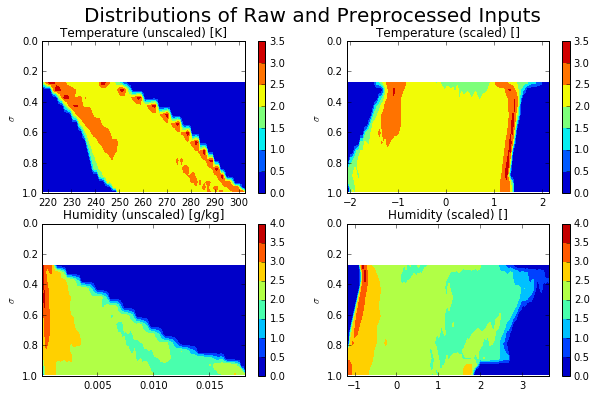

In [4]:
def _plot_distribution(z, lat, lev, fig, ax, titlestr,
                       xl=None, xu=None, bins=None):
    """Plots a stack of histograms of log10(data) at all levels"""
    # Initialize the bins and the frequency
    num_bins = 100
    if bins is None:
        bins = np.linspace(np.amin(z), np.amax(z), num_bins+1)
    n = np.zeros((num_bins, lev.size))
    # Calculate distribution at each level
    for i in range(lev.size):
        n[:,i], _ = np.histogram(z[:,i], bins=bins)
    bins1=bins[:-1]
    # Take a logarithm and deal with case where we take log of 0
    n = np.log10(n)
    n_small = np.amin(n[np.isfinite(n)])
    n[np.isinf(n)]  = n_small
    # Plot histogram
    ca = ax.contourf(bins[:-1], lev, n.T)
    ax.set_ylim(1,0)
    if xl is not None:
        ax.set_xlim(xl,xu)
    plt.colorbar(ca, ax=ax)
    ax.set_ylabel(r'$\sigma$')
    ax.set_title(titlestr)
    xl,xr = ax.set_xlim()
    return xl, xr, bins

# Show how preprocessing scales the input data
fig, ax = plt.subplots(2, 2)
_, _, _ = _plot_distribution(unpack(x_orig, 'T'), lat, lev, fig, ax[0,0], 
                             'Temperature (unscaled) [K]')
_, _, _ = _plot_distribution(unpack(x,      'T'), lat, lev, fig, ax[0,1], 
                             'Temperature (scaled) []')
_, _, _ = _plot_distribution(unpack(x_orig, 'q'), lat, lev, fig, ax[1,0], 
                             'Humidity (unscaled) [g/kg]')
_, _, _ = _plot_distribution(unpack(x,      'q'), lat, lev, fig, ax[1,1],
                             'Humidity (scaled) []')
fig.suptitle('Distributions of Raw and Preprocessed Inputs', fontsize=20)

#### Preprocessing output values

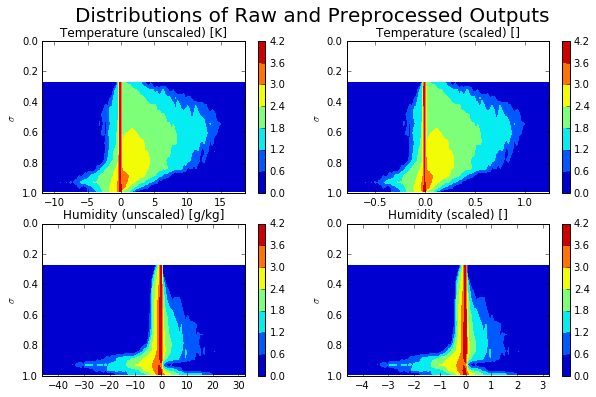

In [5]:
fig, ax = plt.subplots(2, 2)
_, _, _ = _plot_distribution(unpack(y_orig, 'T'), lat, lev, fig, ax[0,0], 
                             'Temperature (unscaled) [K]')
_, _, _ = _plot_distribution(unpack(y,      'T'), lat, lev, fig, ax[0,1], 
                             'Temperature (scaled) []')
_, _, _ = _plot_distribution(unpack(y_orig, 'q'), lat, lev, fig, ax[1,0], 
                             'Humidity (unscaled) [g/kg]')
_, _, _ = _plot_distribution(unpack(y,      'q'), lat, lev, fig, ax[1,1],
                             'Humidity (scaled) []')
fig.suptitle('Distributions of Raw and Preprocessed Outputs', fontsize=20)


## Build Neural Network

#### Functions to build NN

In [6]:
def store_stats(i, avg_train_error, best_train_error, avg_valid_error,
                best_valid_error,**_):
    if i==1:
        global errors_stored
        errors_stored = []
    errors_stored.append((avg_train_error, best_train_error, avg_valid_error,
                          best_valid_error))
    
def build_nn(method, actv_fnc, hid_neur, learning_rule, pp_str,
             batch_size=100, n_iter=None, n_stable=None,
             learning_rate=0.01, learning_momentum=0.9,
             regularize='L2', weight_decay=0.0, valid_size=0.5,
             f_stable=.001):
    """Builds a multi-layer perceptron via the scikit neural network interface"""
    # First build layers
    layers = [sknn.mlp.Layer(f,units=h) for f,h in zip(actv_fnc,hid_neur)]
    # Append a linear output layer
    layers.append(sknn.mlp.Layer("Linear"))
    mlp = sknn.mlp.Regressor(layers, n_iter=n_iter, batch_size=batch_size,
        learning_rule=learning_rule, learning_rate=learning_rate, 
        learning_momentum=learning_momentum, regularize=regularize, 
        weight_decay=weight_decay, n_stable=n_stable, valid_size=valid_size,
        f_stable=f_stable, callback={'on_epoch_finish': store_stats})
    # Create a name for the neural network
    # First build names of each layer
    layerstr = '_'.join([str(h) + f[0] for h, f in zip(hid_neur, actv_fnc)])
    # Get str of appropriate learning rate
    if learning_rule == 'momentum':
        lrn_str = str(learning_momentum)
    else:
        lrn_str = str(learning_rate)
    # Construct name
    mlp_str = pp_str + method[0] + "_" +  layerstr + "_" + \
              learning_rule[0:3] + lrn_str
    # If using regularization, add that to the name too
    if weight_decay > 0.0:
        mlp_str = mlp_str + 'reg' + str(weight_decay)
    # Add the number of iterations too
    mlp_str = mlp_str + '_Niter' + str(n_iter)
    return mlp, mlp_str

#### Build the NN

In [7]:
actv_fnc = ['Rectifier', 'Rectifier']
hid_neur = [50, 25]
learning_rule='momentum'
n_iter = 100

r_mlp, r_str = build_nn('regress', actv_fnc, hid_neur, learning_rule, 
                        pp_str, n_iter=n_iter, learning_momentum=0.9,
                        regularize='L2', weight_decay=1e-4)

## Train the Neural Network

In [8]:
def train_nn(mlp,mlp_str,x,y, w=None):
    """Train each item in a list of multi-layer perceptrons and then score
    on test data. Expects that mlp is a list of MLP objects"""
    # Initialize
    start = time.time()
    # Train the model using training data
    mlp.fit(x, y, w)
    train_score = mlp.score(x, y)
    end = time.time()
    print("Training Score: {:.4f} for Model {:s} ({:.1f} seconds)".format(
                                              train_score, mlp_str, end-start))
    # This is an N_iter x 4 array...see score_stats
    errors = np.asarray(errors_stored) 
    # Return the fitted models and the scores
    return mlp, errors

# Train neural network
r_mlp, r_errors = train_nn(r_mlp, r_str, x, y)

# Save neural network
pickle.dump([r_mlp, r_str, r_errors, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev],
            open('data/regressors/' + r_str + '.pkl', 'wb'))

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Training Score: 0.3580 for Model X-StandardScaler-qTindi_Y-SimpleY-qTindi_r_50R_25R_mom0.9reg0.0001_Niter100 (20.5 seconds)


# Evaluate the NN

Load a more fully trained neural network as well as new (different) data for testing purposes

Also load validation data

In [9]:
# Define a stored neural net to load
r_str = 'X-StandardScaler-qTindi_Y-SimpleY-qTindi_r_60R_60R_mom0.9reg1e-05'
# Load the NN
r_mlp_eval, _, errors, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev = \
       pickle.load(open('./data/regressors/' + r_str + '.pkl', 'rb'))
# Open the ***VALIDATION*** data set
datasource='./data/convection_50day_validation.pkl'
x_unscl, ytrue_unscl, _,_,_,_,_,_ = nnload.loaddata(datasource, minlev=min(lev))
# Scale data using input scalers
x_scl     = nnload.transform_data(x_ppi, x_pp, x_unscl)
ytrue_scl = nnload.transform_data(y_ppi, y_pp, ytrue_unscl)
# Apply neural network to get predicted output
ypred_scl   = r_mlp_eval.predict(x_scl)
ypred_unscl = nnload.inverse_transform_data(y_ppi, y_pp, ypred_scl)

There is some amount of rain 81.9% of the time
There is a rate of >3 mm/day 26.1% of the time
There is convection 85.1% of the time


## Plot error history as a function of iteration number

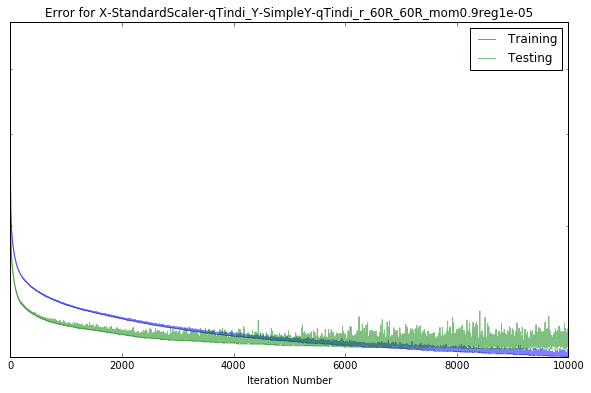

In [10]:
# plot_model_error_over_time(errors, r_str, figpath)
x = np.arange(errors.shape[0])
ytix = [.1e-3, .4e-3, .5e-3, 1e-3, 2e-3, 4e-3, 5e-3, 
        10e-3, 20e-3, 40e-3, 50e-3, 500e-3, 4]
# Plot error rate vs. iteration number
fig=plt.figure()
# Plot training errors
plt.semilogy(x, np.squeeze(errors[:,0]), alpha=0.5,color='blue',label='Training')
plt.semilogy(x, np.squeeze(errors[:,1]), alpha=0.5,color='blue')
plt.yticks(ytix,ytix)
plt.ylim((np.nanmin(errors), np.nanmax(errors)))
# Use a logarithmic y-axis
plt.semilogy(x, np.squeeze(errors[:,2]), alpha=0.5,label='Testing',color='green')
plt.semilogy(x, np.squeeze(errors[:,3]), alpha=0.5,color='green')
plt.legend()
plt.title('Error for ' + r_str)
plt.xlabel('Iteration Number')

## Plot Mean Statistics

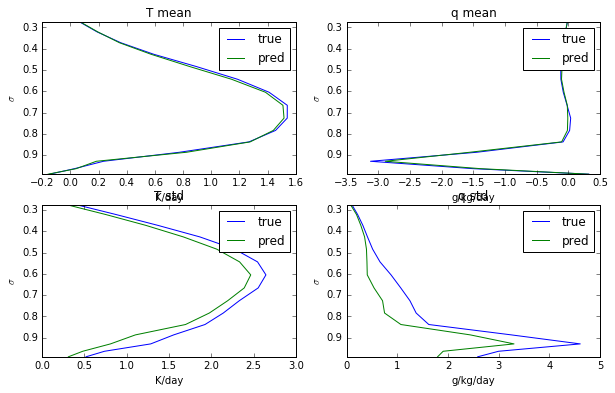

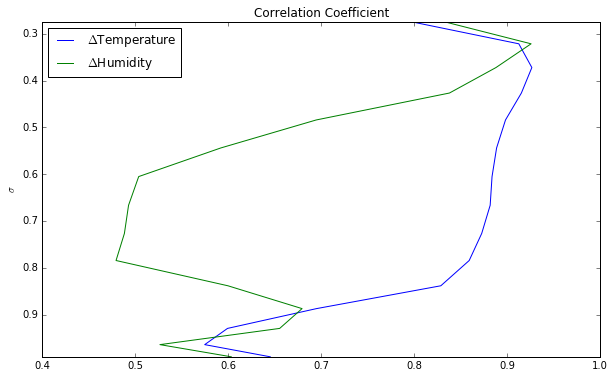

In [11]:
def do_mean_or_std(method, vari, true, pred, lev, ind):
    out_str_dict = {'T':'K/day','q':'g/kg/day'}
    methods = {'mean':np.mean,'std':np.std}
    plt.subplot(2,2,ind)
    m = lambda x: methods[method](unpack(x,vari), axis=0).T
    plt.plot(m(true), lev, label='true')
    plt.plot(m(pred), lev, label='pred')
    plt.ylim(np.amax(lev),np.amin(lev))
    plt.ylabel('$\sigma$')
    plt.xlabel(out_str_dict[vari])
    plt.title(vari + " " + method)
    plt.legend()

def plot_means_stds(y3_true, y3_pred, lev):
    fig = plt.figure()
    do_mean_or_std('mean','T',y3_true,y3_pred, lev, 1)
    do_mean_or_std('mean','q',y3_true,y3_pred, lev, 2)
    do_mean_or_std('std','T',y3_true,y3_pred, lev, 3)
    do_mean_or_std('std','q',y3_true,y3_pred, lev, 4)
    
def plot_pearsonr(y_true, y_pred, vari, lev, label=None):
    r = np.empty(y_true.shape[1])
    prob = np.empty(y_true.shape[1])
    for i in range(y_true.shape[1]):
        r[i], prob[i] = scipy.stats.pearsonr(y_true[:,i],y_pred[:,i])
    plt.plot(unpack(r,vari, axis=0), lev, label=label)
    plt.ylim([np.amax(lev), np.amin(lev)])
    plt.ylabel('$\sigma$')
    plt.title('Correlation Coefficient')
    
# Plot means and standard deviations
plot_means_stds(ytrue_unscl, ypred_unscl, lev)

# Plot correlation coefficient versus height
fig = plt.figure()
plot_pearsonr(ytrue_unscl, ypred_unscl, 'T', lev, label=r'$\Delta$Temperature')
plot_pearsonr(ytrue_unscl, ypred_unscl, 'q', lev, label=r'$\Delta$Humidity')
plt.legend(loc="upper left")

## Check the distribution of output values

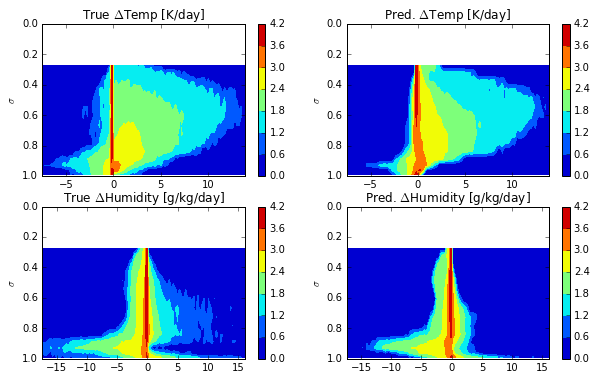

In [12]:
# Plot histogram showing how well true and predicted values match
def check_output_distribution(yt_unscl, yt_scl, yp_unscl, yp_scl, lat, lev):
    # For unscaled variables
    fig, ax = plt.subplots(2, 2)
    x1, x2, bins = _plot_distribution(unpack(ypred_unscl,'T'), lat, lev, fig, ax[0,1], 
                                      r'Pred. $\Delta$Temp [K/day]')
    _ , _ , _    = _plot_distribution(unpack(ytrue_unscl,'T'), lat, lev, fig, ax[0,0],
                                      r'True $\Delta$Temp [K/day]', x1, x2, bins)
    x1, x2, bins = _plot_distribution(unpack(ypred_unscl,'q'), lat, lev, fig, ax[1,1],
                                      r'Pred. $\Delta$Humidity [g/kg/day]')
    _ , _ , _    = _plot_distribution(unpack(ytrue_unscl,'q'), lat, lev, fig, ax[1,0],
                                      r'True $\Delta$Humidity [g/kg/day]', x1, x2, bins)
    
check_output_distribution(ytrue_unscl, ytrue_scl, ypred_unscl, ypred_scl,
                      lat, lev)

## Make a scatter plot of precipitation

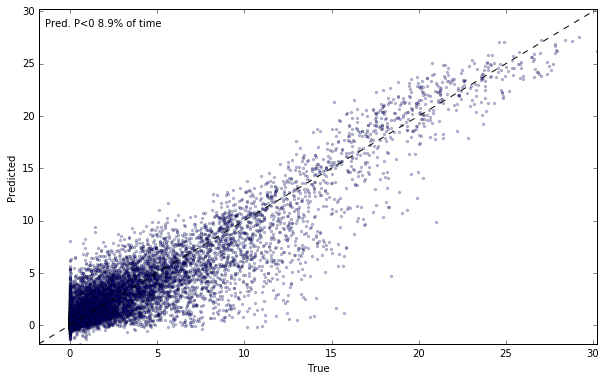

In [13]:
def calc_precip(y, dlev):
    y = unpack(y,'q')
    y = y / 1000. # kg/kg/day
    return vertical_integral(y, dlev) #mm/day

def vertical_integral(data, dlev):
    g = 9.8 #m/s2
    data = -1./g * np.sum(data * dlev[:,None].T, axis=1)*1e5
    return data

# Plot a scatter plot of true vs predicted precip
P_true = calc_precip(ytrue_unscl, dlev)
P_pred = calc_precip(ypred_unscl, dlev)

# Plot data
plt.scatter(P_true, P_pred, s=5, alpha=0.25)
# Calcualte mins and maxs and set axis bounds appropriately
xmin = np.min(P_true)
xmax = np.max(P_true)
ymin = np.min(P_pred)
ymax = np.max(P_pred)
xymin = np.min([xmin,ymin])
xymax = np.max([xmax,ymax])
# Plot 1-1 line
plt.plot([xymin,xymax], [xymin, xymax], color='k', ls='--')
plt.xlim(xymin, xymax)
plt.ylim(xymin, xymax)
plt.xlabel('True')
plt.ylabel('Predicted')

Plessthan0 = sum(P_pred < 0.0)
Plessthan0pct = 100.*Plessthan0/len(P_pred)
plt.text(0.01,0.95,"Pred. P<0 {:.1f}% of time".format(Plessthan0pct),
         transform=plt.gca().transAxes)

## Some examples of the NN in action

Random sample index value: 3499


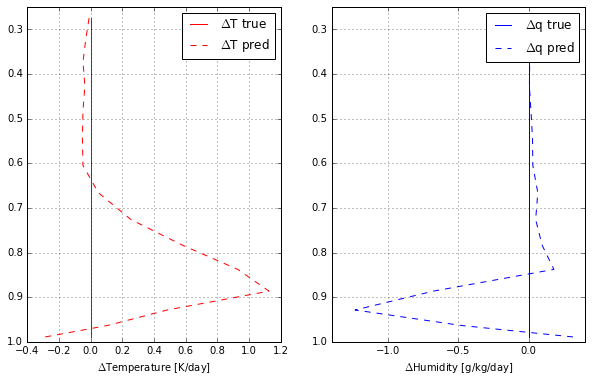

In [17]:
def plot_sample_profile(y_true, y_pred, lev):
    """Plots the vertical profiles of input T & q and 
       predicted and true output tendencies"""
    f, (ax1, ax3) = plt.subplots(1,2)
    T = nnload.unpack(x, 'T', axis=0)
    q = nnload.unpack(x, 'q', axis=0)   
    # Plot temperature tendencies
    ax1.plot(unpack(y_true, 'T', axis=0), lev, color='red' , 
             ls='-' , label=r'$\Delta$T true')
    ax1.plot(unpack(y_pred, 'T', axis=0), lev, color='red' , 
             ls='--', label=r'$\Delta$T pred')
    ax1.set_xlabel(r'$\Delta$Temperature [K/day]')
    # Plot humidity tendencies
    ax3.plot(unpack(y_true, 'q', axis=0), lev, color='blue', 
             ls='-' , label=r'$\Delta$q true')
    ax3.plot(unpack(y_pred, 'q', axis=0), lev, color='blue', 
             ls='--', label=r'$\Delta$q pred')
    ax3.set_xlabel(r'$\Delta$Humidity [g/kg/day]')
    # Set axis properties
    for ax in [ax1, ax3]:
        ax.set_ylim(1, 0.25)
        ax.legend()
        ax.grid(True)
    fig.suptitle('Sample True and Predicted Outputs', fontsize=20)
samp = np.random.randint(0, x.shape[0])
print('Random sample index value: ' + str(samp))
plot_sample_profile(ytrue_unscl[samp,:], ypred_unscl[samp,:], lev)